In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision.utils import make_grid
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from torchvision.models import resnet50
from scipy.spatial.distance import cosine

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# All main hyperparameters
class Conf:
    def __init__(self):
        self.batch_size = 100
        self.num_classes = 10  # number of classes
        self.len_nz = 100  # number of values of noise for the generation
        self.epochs = 500  # number of training epochs as a basic value (100 to get 50k iterations like in the paper)
        self.img_size = 32  # resizing images if needed
        self.loss_adversarial = torch.nn.BCELoss()  # loss from the paper for the discriminator
        self.loss_classification = torch.nn.CrossEntropyLoss()  # loss for the classification
        self.optimizerG = 'Adam'  # optimized for the generator
        self.optimizerD = 'Adam'  # optimized for the discriminator
        self.learning_rate = 0.0001  # learning rate for both
        self.drop_out = 0.5
        self.beta1 = 0.5  # for Adam optimizers
        self.beta2 = 0.999  # for Adam optimizers
        self.relu_slope = 0.2  # sloe in RELU
        self.activation_noise_std = 0.1  # activation noise std
        self.mean = 0  # initialization mean
        self.std = 0.01  # initialization std

In [5]:
conf = Conf()

In [6]:

transform = transforms.Compose([
    transforms.Resize((conf.img_size, conf.img_size)),  # Resize the image
     transforms.ToTensor(),  # Convert the image to a tensor
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the tensor
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=conf.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=conf.batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


tensor(0.8902) tensor(-0.9765)


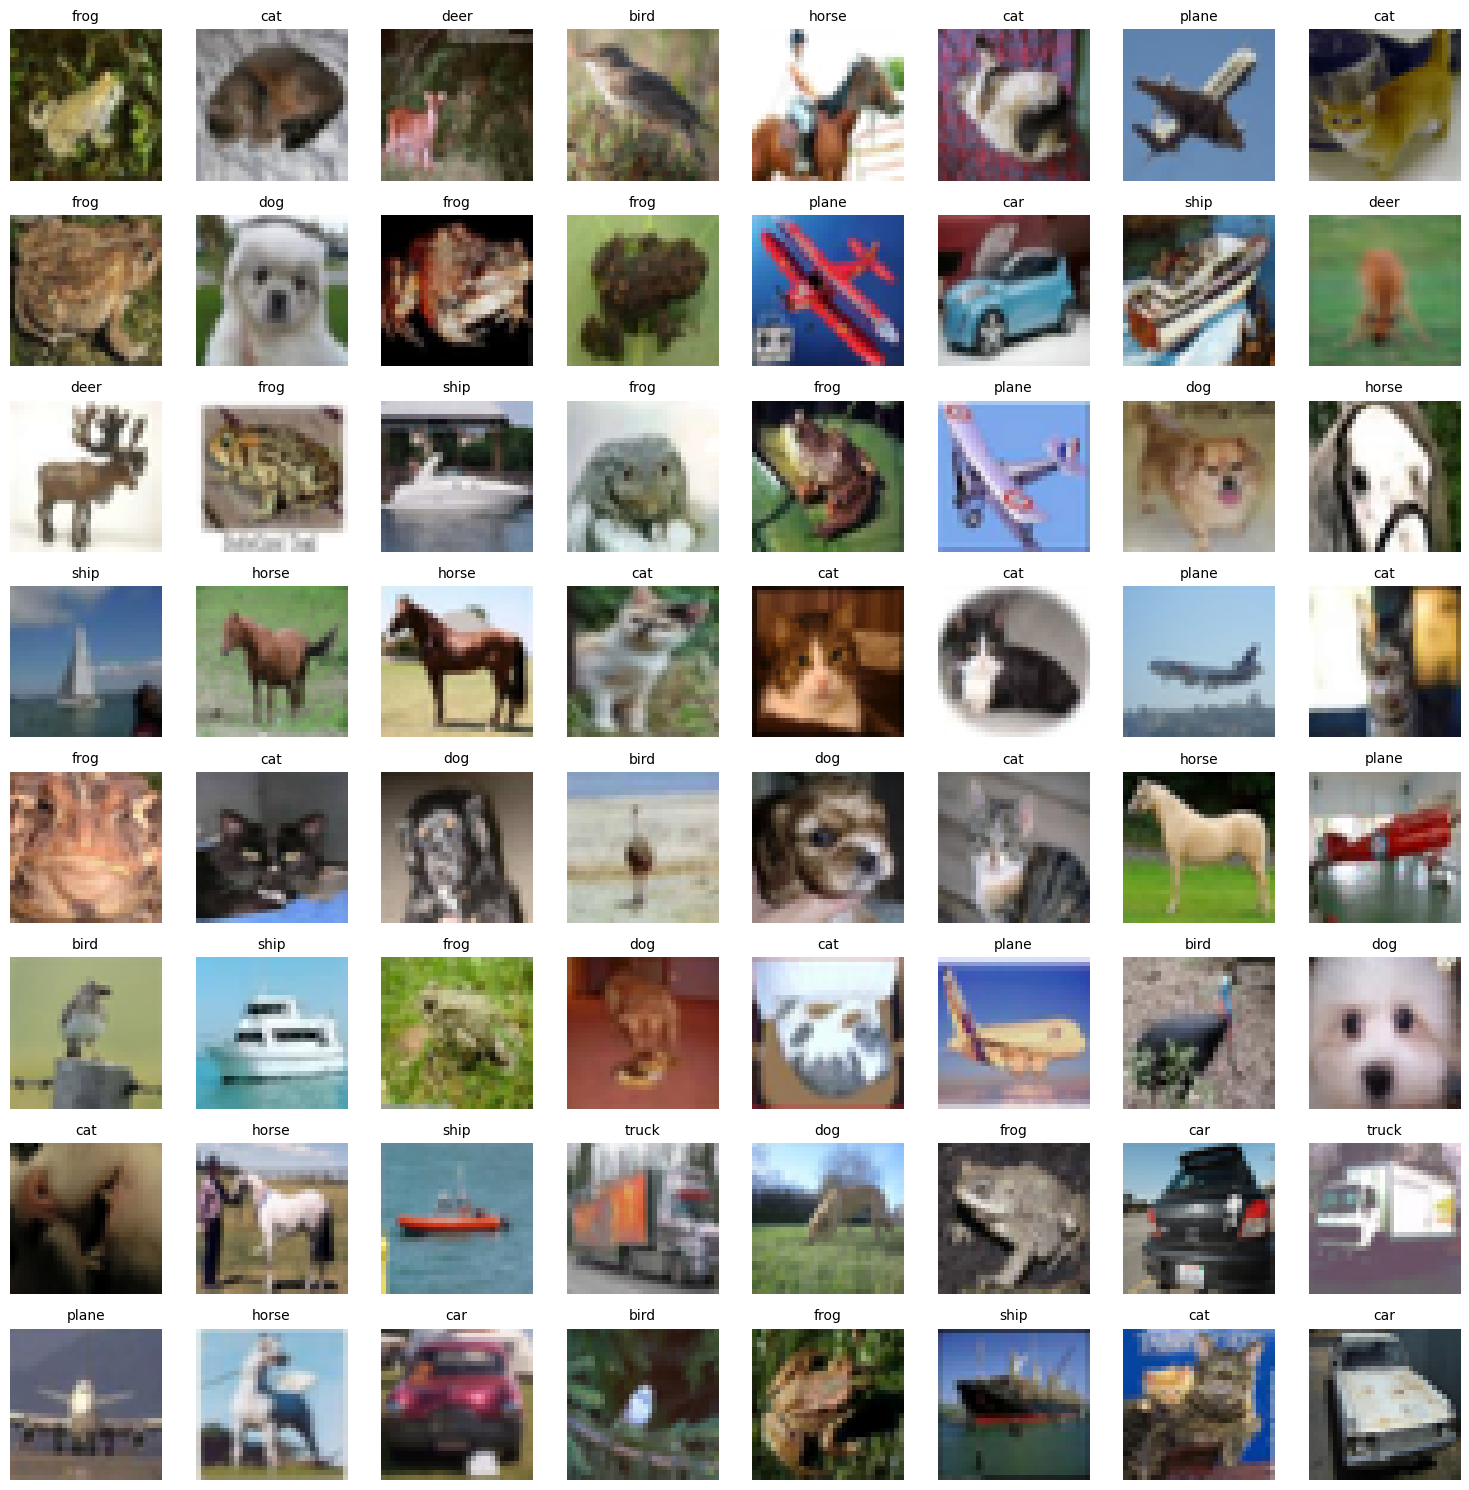

In [7]:
# plotting some images as examples
plt.figure(figsize=(15,15))
num_images = 64
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images[2].max(), images[2].min())
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for idx in range(num_images):
    ax = plt.subplot(8, 8, idx + 1) # Arrange subplots in a 8x8 grid
    plt.imshow(np.transpose((images[idx].numpy() + 1) / 2, (1, 2, 0)))  # rescaling to 0-1 range
    ax.set_title(classes[labels[idx]], fontsize=10) # Set title to the class of the image
    plt.axis('off')
plt.tight_layout()
plt.show()


In [8]:
class Generator_simple(nn.Module):
    def __init__(self):
        super(Generator_simple, self).__init__()
        self.label_emb = nn.Embedding(conf.num_classes, conf.num_classes)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(110, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # nn.Sigmoid()
        )

    def forward(self, noise, labels):
        # input = torch.cat((self.label_emb(labels), noise), dim=1)
        # labels_one_hot = self.nn.functional.one_hot(labels, num_classes=10)
        # input = torch.cat((labels_one_hot, noise), dim=1)
        input = torch.cat((noise, labels), dim=1)
        input_reshaped = input.view(input.shape[0], -1, 1, 1)
        output = self.main(input_reshaped)
        return output


class Discriminator_simple(nn.Module):
    def __init__(self):
        super(Discriminator_simple, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

        )
        self.img_real = nn.Sequential(
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.classification = nn.Sequential(
            nn.Linear(256*4*4, 256),
            nn.Linear(256, conf.num_classes)
        )

    def forward(self, input):
        output = self.main(input)
        # print(output.shape)
        img_real = self.img_real(output).view(-1)
        classification = self.classification(output.view(input.shape[0], -1)).squeeze()
        # print(classification.shape)
        # print(input.shape)
        return img_real, classification

class Generator(nn.Module):
    def __init__(self, conf):
        super(Generator, self).__init__()
        # self.label_emb = nn.Embedding(conf.num_classes, conf.len_nz)
        self.bias = True
        self.label_emb = nn.Embedding(conf.num_classes, conf.num_classes)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(conf.len_nz + conf.num_classes, 384, 4, 1, 0, bias=self.bias),
            nn.ReLU(True),
            # Subsequent layers follow the pattern from the table
            nn.ConvTranspose2d(384, 192, 4, 2, 1, bias=self.bias),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
            nn.ConvTranspose2d(192, 96, 4, 2, 1, bias=self.bias),
            nn.BatchNorm2d(96),
            nn.ReLU(True),
            nn.ConvTranspose2d(96, 3, 4, 2, 1, bias=self.bias),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # labels_one_hot = self.label_emb(labels)
        # labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=10)
        input = torch.cat((noise, labels), dim=1)
        input_reshaped = input.view(input.shape[0], -1, 1, 1)
        output = self.main(input_reshaped)
        # Add activation noise
        # noise = torch.randn_like(output) * 0.1
        return output  # + noise

class Discriminator(nn.Module):
    def __init__(self, conf):
        self.bias = True
        self.drop = conf.drop_out
        self.relu_slope = conf.relu_slope
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1, bias=self.bias),
            nn.LeakyReLU(self.relu_slope, inplace=True),
            nn.Dropout(self.drop),
            nn.Conv2d(16, 32, 3, 1, 1, bias=self.bias),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(self.relu_slope, inplace=True),
            nn.Dropout(self.drop),
            nn.Conv2d(32, 64, 3, 2, 1, bias=self.bias),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(self.relu_slope, inplace=True),
            nn.Dropout(self.drop),
            nn.Conv2d(64, 128, 3, 1, 1, bias=self.bias),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(self.relu_slope, inplace=True),
            nn.Dropout(self.drop),
            nn.Conv2d(128, 256, 3, 2, 1, bias=self.bias),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(self.relu_slope, inplace=True),
            nn.Dropout(self.drop),
            nn.Conv2d(256, 512, 3, 1, 1, bias=self.bias),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(self.relu_slope, inplace=True),
            nn.Dropout(self.drop),

        )

        self.classification = nn.Sequential(
            nn.Linear(512 * 4 * 4, 11),
            nn.Sigmoid()
        )
    def forward(self, input):
        output = self.main(input)
        img_real = output.view(input.shape[0], -1)
        classification = self.classification(img_real)
        return classification[:, 0], classification[:, 1:]

In [9]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


# Initialize Generator and Discriminator




In [10]:


def training_loop(netG, netD, epochs=conf.epochs, conf=conf):
    netG.train()
    netD.train()
    lossesG = []
    lossesD = []
    loss_adversarial = conf.loss_adversarial
    loss_classification = conf.loss_classification

    if conf.optimizerG == 'Adam':
        optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate, betas=(conf.beta1, conf.beta2))
    else:
        optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate, betas=(conf.beta1, conf.beta2))
    if conf.optimizerD == 'Adam':
        optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate, betas=(conf.beta1, conf.beta2))
    else:
        optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate, betas=(conf.beta1, conf.beta2))

    for epoch in range(epochs):
        lossG_tot = 0
        lossD_tot = 0
        for i, (real_images, labels) in enumerate(train_loader):
            # Train Discriminator
            netD.zero_grad()
            real_images = real_images.to(device)
            labels = labels.to(device)
            batch_size = real_images.shape[0]

            # Real images
            real_output, real_class_output = netD(real_images)
            real_source_label = torch.ones(batch_size, device=device)  # Real source label
            real_source_loss = loss_adversarial(real_output, real_source_label)
            real_class_loss = loss_classification(real_class_output, labels)

            # Generate fake images and labels
            noise = torch.randn(batch_size, conf.len_nz, device=device)
            fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)  # Random class labels
            fake_labels_oh = torch.nn.functional.one_hot(fake_labels, num_classes=10)  # Random class labels
            fake_images = netG(noise, fake_labels_oh)
            fake_output, fake_class_output = netD(fake_images.detach())
            fake_source_label = torch.zeros(batch_size, device=device)  # Fake source label
            fake_source_loss = loss_adversarial(fake_output, fake_source_label)
            fake_class_loss = loss_classification(fake_class_output, fake_labels)

            # Combine losses and update discriminator
            lossD = real_source_loss  + fake_source_loss + real_class_loss + fake_class_loss
            lossD.backward()
            optimizerD.step()

            # Train Generator
            netG.zero_grad()

            # Generate fake images and labels
            # noise = torch.randn(batch_size, conf.len_nz, device=device)
            # fake_labels_oh = torch.nn.functional.one_hot(fake_labels, num_classes=10)  # Random class labels
            # fake_images = netG(noise, fake_labels_oh)

            # Discriminator output and target labels
            fake_output, fake_class_output = netD(fake_images)
            fake_source_loss = loss_adversarial(fake_output, real_source_label)
            fake_class_loss = loss_classification(fake_class_output, fake_labels)
            # Generator loss

            # Update generator
            lossG = fake_source_loss + fake_class_loss
            lossG.backward()
            optimizerG.step()

            # saving losses
            lossD_tot += lossD
            lossG_tot += lossG
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {lossD.item()}] [G loss: {lossG.item()}]")
        lossesG.append(lossG_tot.item() / len(train_loader))
        lossesD.append(lossD_tot.item() / len(train_loader))
    return lossesG, lossesD
#


In [11]:
# plotting losses of the discriminator and generator
def plot_losses(lossesG, lossesD):
    epochs = range(1, len(lossesG) + 1)

    # Create the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, lossesG, label='Generator Loss')
    plt.plot(epochs, lossesD, label='Discriminator Loss')
    # Add title and labels
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


[Epoch 0/200] [Batch 0/500] [D loss: 6.080512046813965] [G loss: 3.04555082321167]
[Epoch 0/200] [Batch 100/500] [D loss: 5.887591361999512] [G loss: 3.1718521118164062]
[Epoch 0/200] [Batch 200/500] [D loss: 5.542146682739258] [G loss: 4.165219783782959]
[Epoch 0/200] [Batch 300/500] [D loss: 6.131105422973633] [G loss: 3.0155060291290283]
[Epoch 0/200] [Batch 400/500] [D loss: 5.910702705383301] [G loss: 3.0307204723358154]
[Epoch 1/200] [Batch 0/500] [D loss: 5.546087265014648] [G loss: 3.427076816558838]
[Epoch 1/200] [Batch 100/500] [D loss: 5.397634029388428] [G loss: 2.6053996086120605]
[Epoch 1/200] [Batch 200/500] [D loss: 5.344101905822754] [G loss: 2.5317986011505127]
[Epoch 1/200] [Batch 300/500] [D loss: 5.245882034301758] [G loss: 2.5119142532348633]
[Epoch 1/200] [Batch 400/500] [D loss: 5.237339019775391] [G loss: 2.4202895164489746]
[Epoch 2/200] [Batch 0/500] [D loss: 5.081500053405762] [G loss: 2.375197172164917]
[Epoch 2/200] [Batch 100/500] [D loss: 5.1108183860778

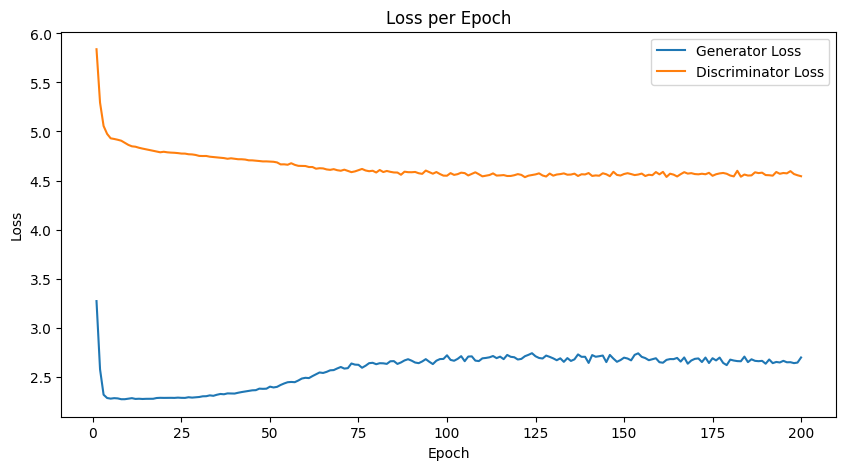

In [12]:
netG = Generator(conf).to(device)
netG.apply(weights_init_normal)
netD = Discriminator(conf).to(device)
netD.apply(weights_init_normal)
# training loop
lossesG, lossesD = training_loop(netG, netD)
plot_losses(lossesG, lossesD)


In [13]:
# def visualize_generated_images(netG, device, num_images=10, nz=conf.len_nz, num_classes=conf.num_classes):
#     netG.eval()  # Set the generator to evaluation mode
#     netD.eval()  # Set the generator to evaluation mode
#
#     # Calculate number of rows needed
#     num_rows = (num_images + 4) // 5  # Add 4 to ensure enough rows for the last few images
#
#     # Generate random noise and labels
#     noise = torch.randn(num_images, nz, device=device)
#     labels = torch.arange(0, num_classes, device=device)
#     print(labels.shape)
#     labels = torch.nn.functional.one_hot(labels, num_classes=10)
#     # print(noise.shape)
#     # Generate images
#     generated_images = netG(noise, labels).detach()
#     img_D, classes_D = netD(generated_images)
#     classes_D = torch.argmax(classes_D, dim=1)
#     print(classes_D)
#     # generated_images = generated_images.cpu()
#     # Move images to CPU and convert to NumPy arrays
#     generated_images = generated_images.to('cpu').numpy()
#
#     # Adjust pixel values to be between 0 and 1
#     generated_images = (generated_images + 1) / 2
#     generated_images = np.clip(generated_images, 0, 1)
#
#     # Plot the images
#     fig, axes = plt.subplots(num_rows, 5, figsize=(16, 5 * num_rows))
#
#     for i in range(num_images):
#         row = i // 5
#         col = i % 5
#         ax = axes[row, col]
#         ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
#         ax.axis('off')
#         ax.set_title(f'{classes[i]}')
#
#     # Hide unused axes (if any)
#     for i in range(num_images, num_rows * 5):
#         row = i // 5
#         col = i % 5
#         axes[row, col].axis('off')
#
#     plt.show()



def show_images(images, num_images, nrow=10, names=None, name_scale=1):
    plt.figure(figsize=(15 / 10 * nrow, 15))
    images = make_grid(images.cpu()[:num_images], nrow=nrow, padding=2, pad_value=1)
    images =  np.clip(images, 0, 1)
    npimg = images.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    single_img_height = npimg.shape[1] // (num_images // nrow) * name_scale
    if names is not None:
        for i, name in enumerate(names):
            if i >= num_images:
                break  # Break if there are more names than images
            row = i // nrow - 1
            col = i % nrow
            plt.text(col * single_img_height + single_img_height / 2, (row + 1) * single_img_height - single_img_height * 0.14,
                     name, ha='center', va='top', fontsize=12, color='black',
                     bbox=dict(facecolor='white', alpha=0.5, edgecolor='white', boxstyle='round,pad=0.1'))
    plt.show()

def generate_images(net_gen, num_images, image_classes, noise_dim=conf.len_nz):
    # Generate random noise
    noise = torch.randn(num_images, noise_dim, device=device)
    classes_one_hot = np.zeros((num_images, conf.num_classes))
    for i in range(num_images):
        classes_one_hot[i, image_classes[i]] = 1
    classes_one_hot = torch.tensor(classes_one_hot).to(device).float()
    # Generate images from noise
    with torch.no_grad():
        net_gen.eval()
        images = net_gen(noise, classes_one_hot)
        images = (images + 1) / 2  # Rescale images from [-1,1] to [0,1] if needed
    return images

def show_images_quick(num_rows=1):
    images_classes = [it for it in range(10)] * num_rows
    names_classes = [classes[it] for it in images_classes[:10]]
    generated_images = generate_images(netG, 10 * num_rows, images_classes)
    show_images(generated_images, num_images=10 * num_rows, nrow=10, names=names_classes, name_scale=0.975)

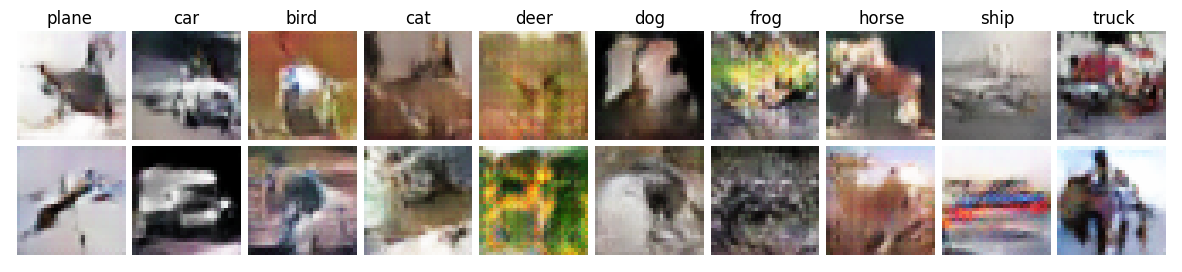

In [14]:
show_images_quick(num_rows=2)

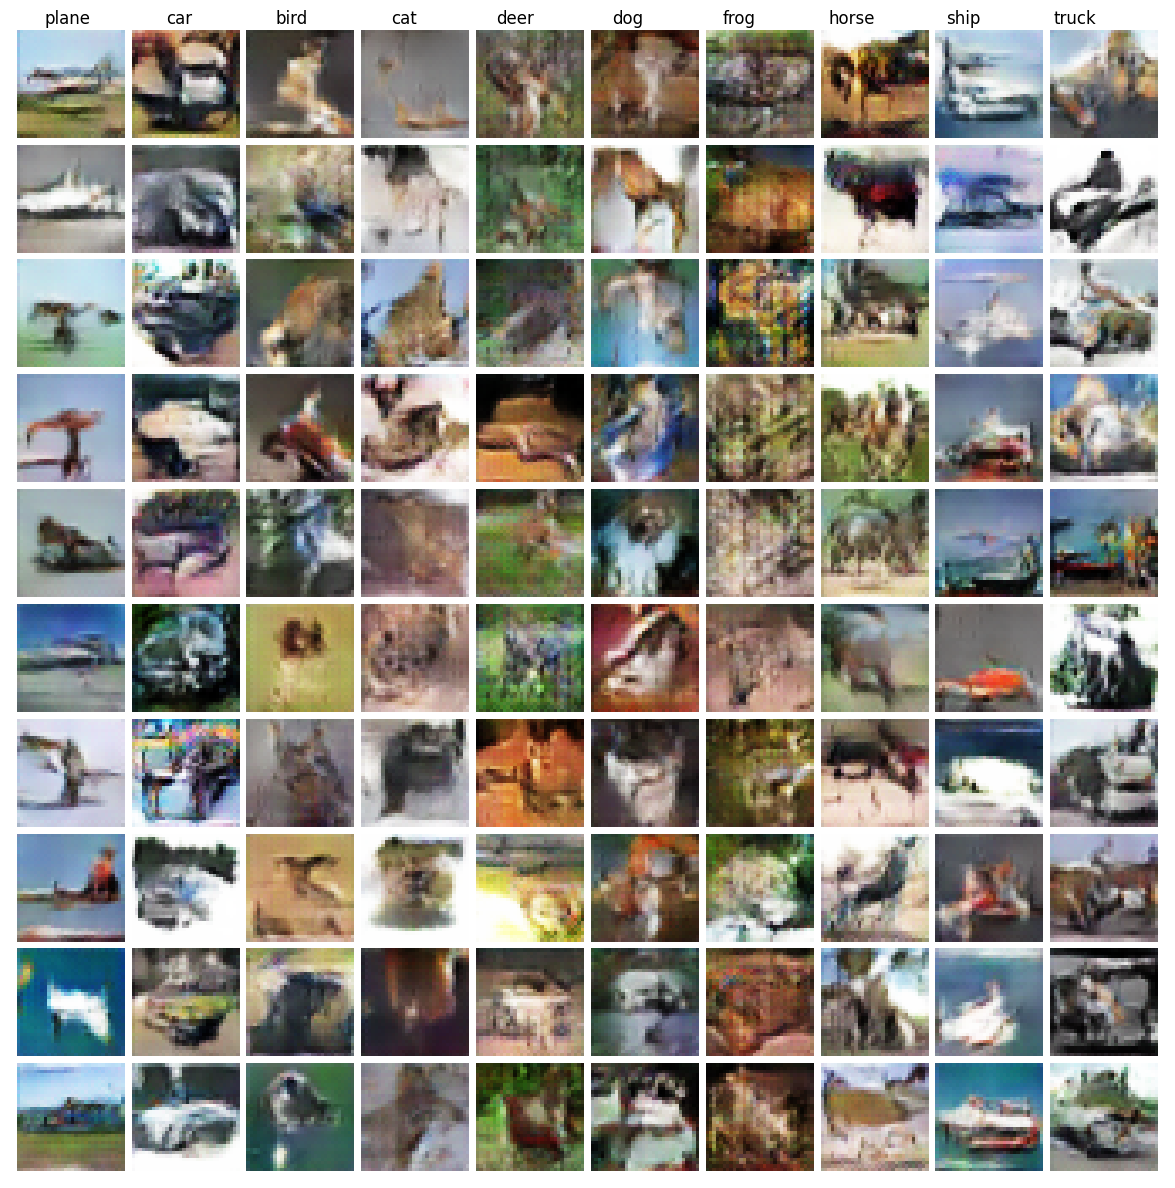

In [15]:
show_images_quick(num_rows=10)

In [18]:
torch.save(netG.state_dict(), 'netG200.pth')
torch.save(netD.state_dict(), 'netD200.pth')

In [19]:

netG = Generator(conf).to(device)
netD = Discriminator(conf).to(device)
# Load the weights back into the models
netG.load_state_dict(torch.load('netG200.pth'))
netD.load_state_dict(torch.load('netD200.pth'))
# Make sure to call eval() if you're in inference mode
netG.eval()
netD.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.5, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout(p=0.5, inplace=False)
    (15): Conv2d(128, 

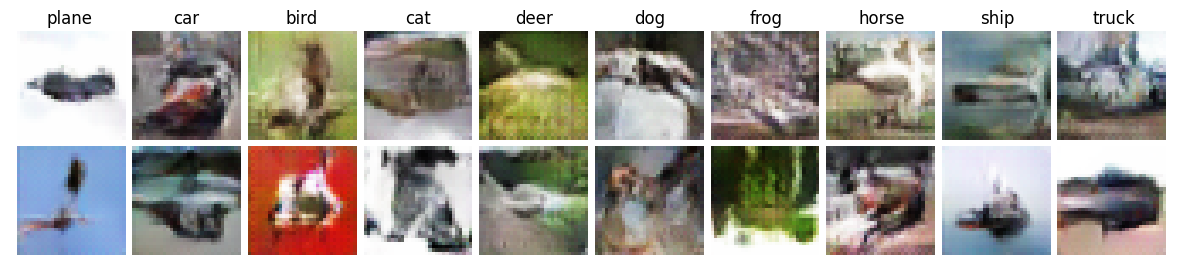

In [20]:
show_images_quick(num_rows=2)

In [21]:
# from torchviz import make_dot
# noise = torch.randn(10, 100)
# labels = torch.arange(0, 10)
# labels = torch.nn.functional.one_hot(labels, num_classes=10)
# output = netG.cpu()(noise, labels).cpu()
# dot = make_dot(output, params=dict(list(netG.cpu().named_parameters()) + [('noise', noise), ('labels', labels)]))
# dot.render('generator_network', format='png')  # Saves the diagram as a PNG file

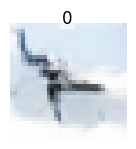

In [22]:
z1 = torch.randn(1, 100, device=device)
label1 = torch.tensor([0]).to(device)
label1_oh = torch.nn.functional.one_hot(label1, num_classes=10)

generated_images = netG.to(device)(z1, label1_oh).detach()
generated_images = (generated_images + 1) / 2
show_images(generated_images, num_images=1, nrow=1, names=[0], name_scale=0.95)

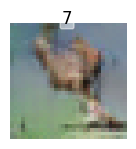

In [23]:
z2 = torch.randn(1, 100, device=device)
label2 = torch.tensor([7]).to(device)
label2_oh = torch.nn.functional.one_hot(label2, num_classes=10)

generated_images = netG.to(device)(z2, label2_oh).detach()
generated_images = (generated_images + 1) / 2
show_images(generated_images, num_images=1, nrow=1, names=[7], name_scale=0.95)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], device='cuda:0')


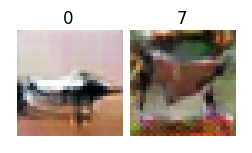

In [24]:
z1 = torch.randn(1, 100, device=device)
z2 = torch.randn(1, 100, device=device)
label1 = torch.tensor([0]).to(device)
label1_oh = torch.nn.functional.one_hot(label1, num_classes=10)
label2 = torch.tensor([7]).to(device)
label2_oh = torch.nn.functional.one_hot(label2, num_classes=10)

z12 = torch.stack((z1, z2)).to(device).view(-1, 100)
label12_oh = torch.stack((label1_oh, label2_oh)).to(device).view(-1, 10)
print(label12_oh)

generated_images = netG.to(device)(z12, label12_oh).detach()
generated_images = (generated_images + 1) / 2
show_images(generated_images, num_images=2, nrow=2, names=[0, 7], name_scale=0.95)

In [25]:

# img_D, classes_D = netD(generated_images)
# classes_D = torch.argmax(classes_D, dim=1)
# generated_images = generated_images.to('cpu').numpy()
#
# generated_images = (generated_images + 1) / 2
# generated_images = np.clip(generated_images, 0, 1)

# Plot the images
# fig, axes = plt.subplots(1, 2, figsize=(16, 5 * 1))
#
# for i in range(2):
#     # row = i // 5
#     # col = i % 5
#     ax = axes[i]
#     ax.imshow(np.transpose(generated_images[i], (1, 2, 0)))
#     ax.axis('off')
#     ax.set_title(f'{classes[i]}')

# # Hide unused axes (if any)
# for i in range(num_images, num_rows * 5):
#     row = i // 5
#     col = i % 5
#     axes[row, col].axis('off')

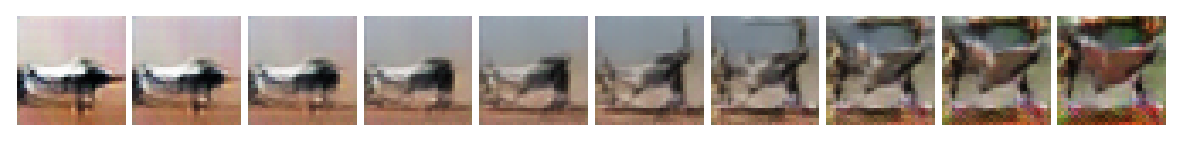

In [26]:
# Function to interpolate between two points in latent space
def interpolate(z1_wl, z2_wl, num_steps=10, device=device):
    alpha_values = torch.linspace(0, 1, steps=num_steps).to(device)
    return (1 - alpha_values.view(-1, 1)) * z1_wl + alpha_values.view(-1, 1) * z2_wl

def interpolate_classes(z1, num_classes=10, device=device):
    z_repeated = z1.repeat(num_classes, 1)
    one_hot_matrix = torch.eye(num_classes).to(device)
    return torch.cat((z_repeated, one_hot_matrix), dim=1).to(device)

num_steps = 10
z1_wl = torch.cat((z1, label1_oh), dim=1)
z2_wl = torch.cat((z2, label2_oh), dim=1)
z_inter = interpolate(z1_wl, z2_wl, num_steps=num_steps)
generated_images = netG.to(device)(z_inter[:, :100], z_inter[:, 100:]).detach()
generated_images = (generated_images + 1) / 2
show_images(generated_images, num_images=num_steps, nrow=num_steps)

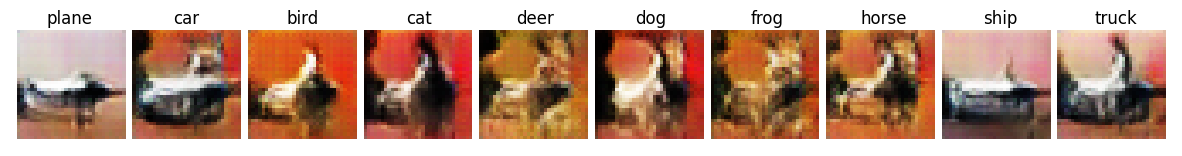

In [27]:
z_classes = interpolate_classes(z1, num_classes=10)
generated_images = netG.to(device)(z_classes[:, :100], z_classes[:, 100:]).detach()
generated_images = (generated_images + 1) / 2
names_classes = [classes[it] for it in range(10)]
show_images(generated_images, num_images=num_steps, nrow=num_steps, names=names_classes, name_scale=0.95)

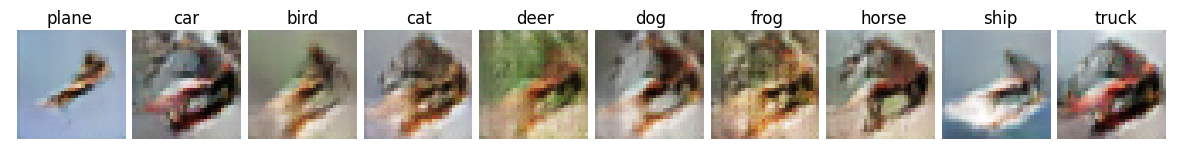

In [28]:
z22 = torch.randn(1, 100, device=device)
z_classes = interpolate_classes(z22, num_classes=10)
generated_images = netG.to(device)(z_classes[:, :100], z_classes[:, 100:]).detach()
generated_images = (generated_images + 1) / 2
names_classes = [classes[it] for it in range(10)]
show_images(generated_images, num_images=num_steps, nrow=num_steps, names=names_classes, name_scale=0.95)

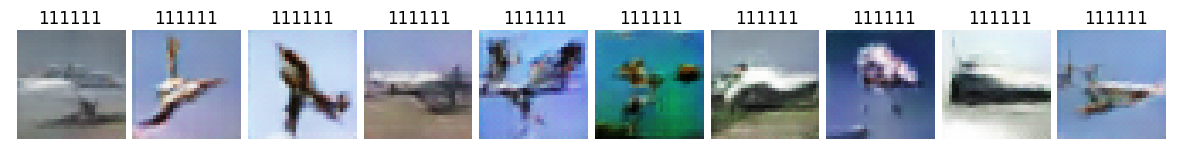

In [29]:


netG_no_last = nn.Sequential(*list(netG.children())[:-1])  # Removing the final layer
netG_no_last.eval()
num_images = 10
generated_images = generate_images(netG, num_images, [0] * num_images)


show_images(generated_images, num_images=10, nrow=10, names=[111111] * 10, name_scale=0.95)

SIMILARITY

In [30]:
# Load a pre-trained ResNet model
model = resnet50(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(model.children())[:-1])  # Removing the final layer
feature_extractor.eval()

C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Cmex-\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


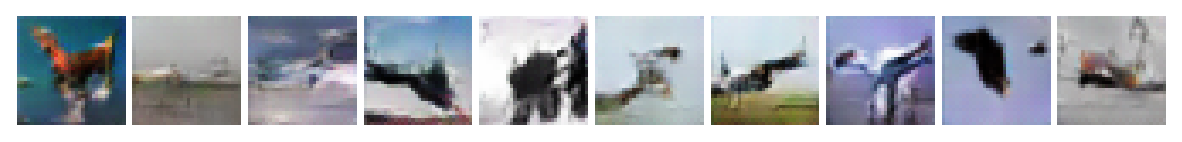

In [31]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def get_features(image, feature_extractor):
    """ Convert image to tensor, normalize, and pass through the model """
    image = normalize(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        features = feature_extractor(image)
    return features.flatten()

def cosine_similarity(feat1, feat2):
    """ Compute the cosine similarity between two feature vectors """
    return torch.nn.functional.cosine_similarity(feat1, feat2, dim=0)

num_images = 100
images_classes_ = [[it] * (num_images // 10) for it in range(10)]
images_classes = [item for sublist in images_classes_ for item in sublist]
generated_images = generate_images(netG, num_images, images_classes)
show_images(generated_images, num_images=10, nrow=10, names=None, name_scale=0.975)
# Assuming you have two images img1 and img2 as PIL Images
# feat1 = get_features(generated_images[0], feature_extractor)
# feat2 = get_features(generated_images[1], feature_extractor)
# similarity = cosine_similarity(feat1, feat2)
features = [get_features(image, feature_extractor) for image in generated_images]
def cosine_similarities(features):
    num_images = len(features)
    similarities = []
    for i in range(num_images):
        for j in range(i + 1, num_images):
            sim = 1 - cosine(features[i].cpu().numpy(), features[j].cpu().numpy())
            similarities.append(sim)
    return similarities

similarities = cosine_similarities(features)
# print(f"Similarity: {similarity.item()}")

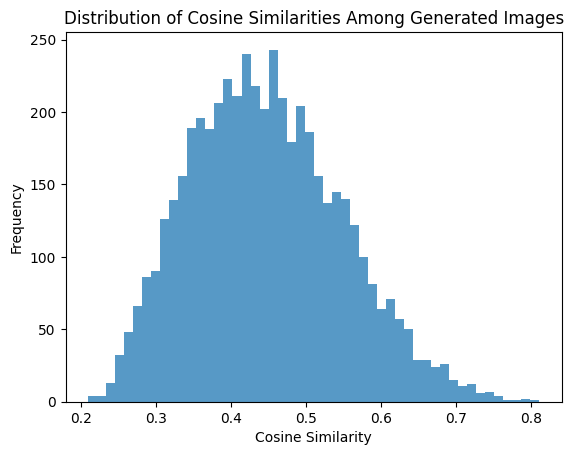

Mean Cosine Similarity: 0.44710433654712906
Standard Deviation of Cosine Similarity: 0.10062364322529488


In [32]:
plt.hist(similarities, bins=50, alpha=0.75)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarities Among Generated Images')
plt.show()
mean_similarity = np.mean(similarities)
std_dev_similarity = np.std(similarities)

print("Mean Cosine Similarity:", mean_similarity)
print("Standard Deviation of Cosine Similarity:", std_dev_similarity)

ACCURACY

In [33]:
def get_images_labels(num_images, dataloader):
    images, labels = [], []
    count = 0

    for batch_images, batch_labels in dataloader:
        # Calculate how many samples are needed to reach n
        if count + batch_images.size(0) > num_images:
            excess = num_images - count
            images.append(batch_images[:excess])
            labels.append(batch_labels[:excess])
            break
        else:
            images.append(batch_images)
            labels.append(batch_labels)
            count += batch_images.size(0)

    # Concatenate all collected batches
    images = torch.cat(images, 0)
    labels = torch.cat(labels, 0)

    return images, labels

In [34]:
num_images_acc = 10000
noise = torch.randn(num_images_acc, 100, device=device)
fake_labels = torch.randint(0, conf.num_classes, (num_images_acc,), device=device)  # Random class labels
fake_labels_oh = torch.nn.functional.one_hot(fake_labels, num_classes=10)
fake_images = netG(noise, fake_labels_oh).detach()
real_images, real_labels = get_images_labels(num_images_acc, train_loader)

def discriminator_accuracy(discriminator, real_images, real_labels, fake_images, fake_labels):
    discriminator.eval()
    with torch.no_grad():
        # Real images
        real_preds, real_class_preds = discriminator(real_images.to(device))
        real_correct = ((real_preds > 0.5).squeeze() == 1).sum().item()
        real_class_correct = (real_class_preds.argmax(dim=1) == real_labels.to(device)).sum().item()

        # Fake images
        fake_preds, fake_class_preds = discriminator(fake_images.to(device))
        fake_correct = ((fake_preds > 0.5).squeeze() == 0).sum().item()
        fake_class_correct = (fake_class_preds.argmax(dim=1) == fake_labels.to(device)).sum().item()

    real_total = real_images.size(0)
    fake_total = fake_images.size(0)
    real_vs_fake_accuracy = (real_correct + fake_correct) / (real_total + fake_total)
    class_accuracy_real = real_class_correct / real_total
    class_accuracy_fake = fake_class_correct / fake_total

    return real_vs_fake_accuracy, class_accuracy_real, class_accuracy_fake


# Calculate accuracies
real_vs_fake_acc, class_acc_real, class_acc_fake = discriminator_accuracy(netD, real_images, real_labels, fake_images, fake_labels)
print(f"Real vs. Fake Discrimination Accuracy: {real_vs_fake_acc * 100:.2f}%")
print(f"Class Accuracy on Real Data: {class_acc_real * 100:.2f}%")
print(f"Class Accuracy on Generated Data: {class_acc_fake * 100:.2f}%")

Real vs. Fake Discrimination Accuracy: 50.00%
Class Accuracy on Real Data: 9.89%
Class Accuracy on Generated Data: 10.51%


In [35]:
# netGs = Generator_simple().to(device)
# # netGs.apply(weights_init_normal)
# netDs = Discriminator_simple().to(device)
# # netDs.apply(weights_init_normal)
# confs = Conf()
# confs.learning_rate = 0.00001
# lossesGs, lossesDs = training_loop(netGs, netDs, conf=confs)
# plot_losses(lossesGs, lossesDs)
# visualize_generated_images(netGs, device)
# torch.save(netGs.state_dict(), 'netGs.pth')
# torch.save(netDs.state_dict(), 'netDs.pth')
# netGs = Generator_simple().to(device)
# netDs = Discriminator_simple().to(device)
# # Load the weights back into the models
# netG.load_state_dict(torch.load('netGs.pth'))
# netD.load_state_dict(torch.load('netDs.pth'))
# # Make sure to call eval() if you're in inference mode
# netG.eval()
# netD.eval()
# netG200, netD200 = netG, netD
# lossesG200, lossesD200 = training_loop(netG200, netD200)
# plot_losses(lossesG200, lossesD200)
# visualize_generated_images(netG200, device)

In [36]:
# def testing_loop(netG, netD):
#     netG.eval()
#     netD.eval()
#     lossesG = []
#     lossesD = []
#     loss_adversarial = conf.loss_adversarial
#     loss_classification = conf.loss_classification
#
#     if conf.optimizerG == 'Adam':
#         optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate)
#     else:
#         optimizerG = optim.Adam(netG.parameters(), lr=conf.learning_rate)
#     if conf.optimizerD == 'Adam':
#         optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate)
#     else:
#         optimizerD = optim.Adam(netD.parameters(), lr=conf.learning_rate)
#     # schedulerG = lr_scheduler.ReduceLROnPlateau(optimizerG, factor=0.3, patience=5)  # Adjust parameters as needed
#     # schedulerD = lr_scheduler.ReduceLROnPlateau(optimizerD, factor=0.3, patience=5)
#     lossD_total = 0
#     lossG_total = 0
#     for i, (real_images, labels) in enumerate(test_loader):
#         # ---------------------
#         # Train Discriminator
#         # ---------------------
#         netD.zero_grad()
#         real_images = real_images.to(device)
#         # labels = labels.to(device)
#         batch_size = real_images.shape[0]
#         # Real images
#         real_output = netD(real_images)  # Get source and class outputs
#         # print(real_output.shape)
#         real_source_label = torch.ones(batch_size, device=device)  # Real source label
#         real_source_loss = loss_adversarial(real_output, real_source_label)
#         # real_class_loss = loss_classification(real_class_output, labels)
#
#         # Fake images
#         noise = torch.randn(batch_size, conf.len_nz, device=device)
#         # print(noise.shape)
#         fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)  # Random class labels
#         fake_images = netG(noise, fake_labels)
#         fake_output = netD(fake_images.detach())  # Get source and class outputs
#         fake_source_label = torch.zeros(batch_size, device=device)  # Fake source label
#         fake_source_loss = loss_adversarial(fake_output, fake_source_label)
#         # fake_class_loss = loss_classification(fake_class_output, fake_labels)
#
#         # Combine losses and update discriminator
#         lossD = real_source_loss  + fake_source_loss #+ real_class_loss # + fake_class_loss
#         # lossD.backward()
#         # optimizerD.step()
#
#         # ---------------------
#         # Train Generator
#         # ---------------------
#         netG.zero_grad()
#
#         # Generate fake images and labels
#         noise = torch.randn(batch_size, conf.len_nz, device=device)
#         fake_labels = torch.randint(0, conf.num_classes, (batch_size,), device=device)
#         fake_images = netG(noise, fake_labels)
#
#         # Discriminator output and target labels
#         fake_output = netD(fake_images)  # Get source and class outputs
#         # real_source_label = torch.ones(batch_size, 1, device=device)  # Target real source label
#
#         # Generator loss
#         lossG = loss_adversarial(fake_output, real_source_label) #+ loss_classification(fake_class_output, fake_labels)
#         # schedulerG.step(lossD)
#         # schedulerD.step(lossG)
#         # Update generator
#         # lossG.backward()
#         # optimizerG.step()
#         lossD_total += lossD
#         lossG_total += lossG
#         # lossesG.append(lossG)
#         # lossesD.append(lossD)
#         # if i % 100 == 0:
#         #     print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(train_loader)}] [D loss: {lossD.item()}] [G loss: {lossG.item()}]")
#     print(f'loss D: {lossD_total}, loss G: {lossD_total}')
#     return lossesG, lossesD
